$$
\Large{\textbf{Prédiction Conformelle - UE TER 2023}}
$$

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

Génération des données :

In [51]:
np.random.seed(1)

Importation de SKLEARN pour implémenter le modèle

In [52]:
from sklearn.linear_model import LinearRegression

In [53]:
reg_OLS = LinearRegression()
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor

k=9
reg_neigh = KNeighborsRegressor(n_neighbors = k)

# SPLIT CONFORMAL

In [54]:
beta0 = 5
n_train=100
X_train = np.random.rand(n_train,1)
Y_train=beta0*X_train + 1/2*np.random.randn(n_train,1)

n_test=30
x_test = np.random.rand(n_test,1)
y_test = beta0*x_test + 1/2*np.random.randn(n_test,1)

## Pour la régression linéaire :

In [55]:
def split_conformal_prediction(x_cal, y_cal, X_train, Y_train, reg, beta):
    n_cal=x_cal.shape[0]
    reg.fit(X_train, Y_train)
    
    V=np.zeros(n_cal)
    for i in range(n_cal):
        V[i] = np.abs(y_cal[i]-reg.predict(x_cal[i].reshape(-1,1)))
    
    quantile = np.quantile(V,beta*(1+1/n_cal))
    
    return quantile

Tracé :

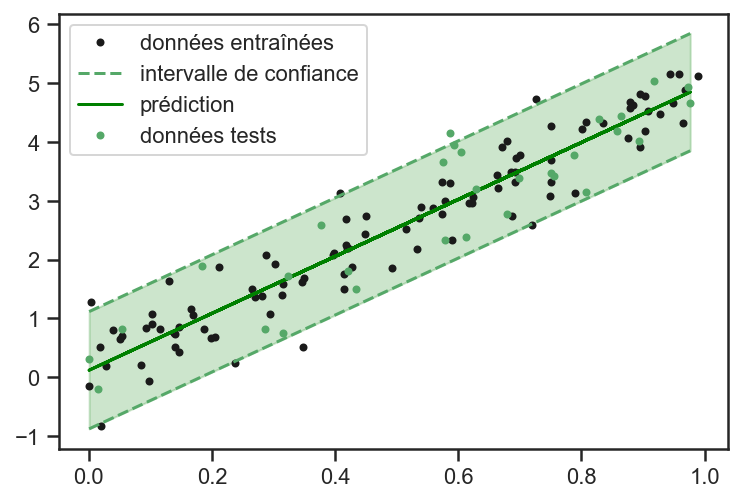

In [56]:
n_cal=20
x_cal=np.random.rand(n_cal,1)
y_cal=beta0*x_cal + 1/2*np.random.randn(n_cal,1)

reg_OLS.fit(X_train,Y_train)

plt.plot(X_train,Y_train,'k.', label='données entraînées')

SCP = split_conformal_prediction(x_cal, y_cal, X_train, Y_train, reg_OLS, 0.9)

idx = np.argsort(np.ravel(x_test))

low = reg_OLS.predict(x_test[idx]) - np.full(shape=(n_test,1), fill_value=SCP)
high = reg_OLS.predict(x_test[idx]) + np.full(shape=(n_test,1), fill_value=SCP)

plt.plot(x_test[idx],np.sort(low.ravel()),'g--',label='intervalle de confiance')
plt.plot(x_test[idx],np.sort(high.ravel()),'g--')
plt.plot(x_test, reg_OLS.predict(x_test), color='green',label='prédiction')

plt.fill_between(x_test[idx].reshape(-1,),np.sort(low[:,0]).reshape(-1,),np.sort(high[:,0]).reshape(-1,),color='green',alpha=.2)

plt.plot(x_test,y_test,'g.', label='données tests')

plt.legend()
plt.show()

## pour les $k$-plus proches voisins, avec $k=9$

Génération des données

In [57]:
np.random.seed(1)

#### Données entraînées et tests pour les $k$-plus proches voisins:

In [58]:
n=120
x=4*np.random.rand(n,1) - 2
y = x**2 + 1/3*np.random.randn(n,1)
y=np.ravel(y)

X_train, X_cal, Y_train, Y_cal = train_test_split(x,y,test_size=0.2)

x_test=4*np.random.rand(n_test,1) - 2
y_test= x_test**2 + 1/3*np.random.randn(n_test,1)

#### Tracé :

In [59]:
reg_neigh.fit(X_train, Y_train)
SCP = split_conformal_prediction(X_cal, Y_cal, X_train, Y_train, reg_neigh, 0.9)

(1, 30)


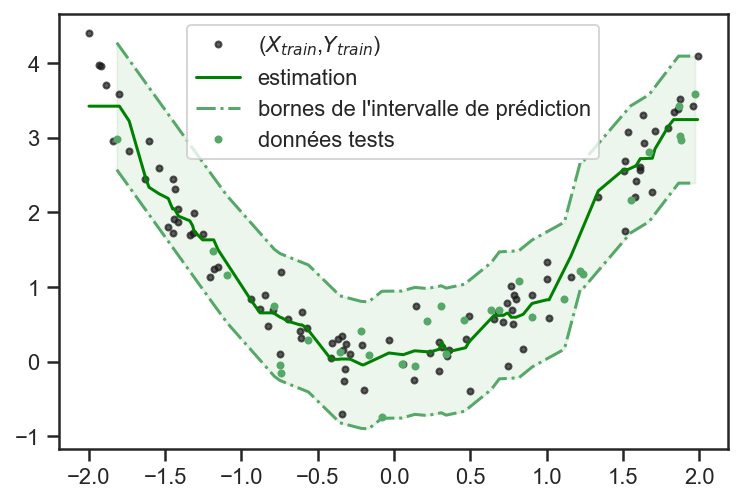

In [60]:
plt.plot(X_train.reshape(-1,),Y_train, 'k.', alpha=.7, label="($X_{train}$,$Y_{train}$)") 
plt.plot(np.sort(X_train[:,0]), reg_neigh.predict(np.sort(X_train[:,0]).reshape(-1,1)), color='green',label='estimation') # affichage de nos y estimés

idx = np.argsort(np.ravel(x_test))

low = reg_neigh.predict(x_test[idx]) - np.full(shape=(1,n_test), fill_value=SCP)
high = reg_neigh.predict(x_test[idx]) + np.full(shape=(1,n_test), fill_value=SCP)

print(low.shape)
plt.plot(x_test[idx], low.ravel() , 'g-.',label="bornes de l'intervalle de prédiction")
plt.plot(x_test[idx], high.ravel(), 'g-.')

plt.fill_between(x_test[idx].reshape(-1,), low.ravel(), high.ravel(),color='green',alpha=.07)

plt.plot(x_test,y_test,'g.', label='données tests')

plt.legend()
plt.show()

gabriel peyré numérical tour - python OPTIMIZATION  MACHINE LEARNING

# FULL CONFORMAL

In [61]:
def full_conformal(x,y,X_train,Y_train,reg,beta):
    n = X_train.shape[0]
    reg.fit(np.append(X_train,x).reshape(n+1,1), np.append(Y_train,y).reshape(n+1,1))
    
    V = np.zeros(n)
    for i in range(n):
        V[i] = np.abs(Y_train[i].reshape(1,1) - reg.predict(X_train[i].reshape(1,1)))
        
    V_ord = np.sort(V)
    return (1 + np.sum( V_ord<= np.abs(y - reg.predict(x.reshape(-1,1)))) ) / (n+1)

## Full Conformal pour la régréssion linéaire

In [62]:
n=100
x = np.random.rand(n,1)
y = beta0*x + 1/2*np.random.randn(n,1)
y = np.ravel(y)

X_train, x_test, Y_train, y_test = train_test_split(x,y,test_size=0.2)

In [63]:
xlist = np.linspace(np.min(X_train), np.max(X_train), 30)
ylist = np.linspace(np.min(Y_train), np.max(Y_train), 20)

In [64]:
reg_OLS.fit(X_train,Y_train)

R = np.zeros((30, 20))
for i in range(30):
    for j in range(20):
        R[i,j] = full_conformal(xlist[i], ylist[j], X_train, Y_train, reg_OLS, 0.9)

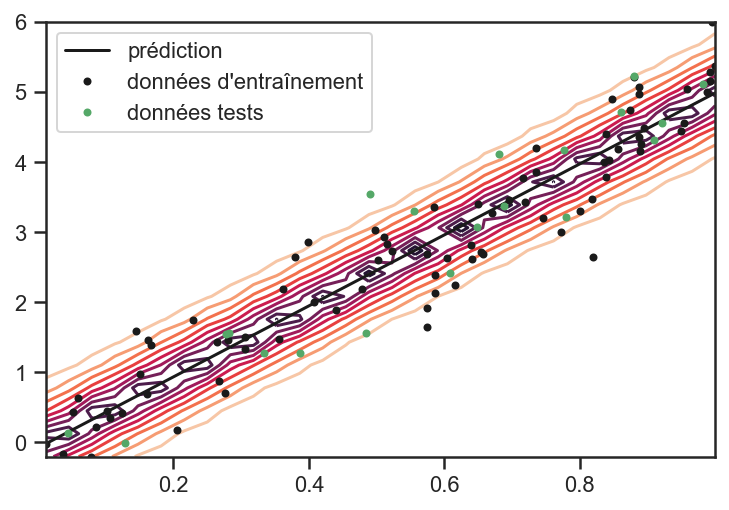

In [65]:
plt.contour(xlist.ravel(),ylist.ravel(), R.T, levels = np.linspace(0,1,11))

plt.plot(xlist, reg_OLS.predict(xlist.reshape(-1,1)).ravel(), 'k-', label='prédiction')
plt.plot(X_train,Y_train, 'k.', label="données d'entraînement")
plt.axis([min(X_train),max(X_train),min(Y_train),max(Y_train)])
plt.plot(x_test,y_test,'g.', label='données tests')
plt.legend()
plt.show()

## Full Conformal pour les $k$-plus proches voisins, pour $k = 9$

#### Données :

In [66]:
n=120
x=4*np.random.rand(n,1) - 2
y = x**2 + 1/3*np.random.randn(n,1)
y=np.ravel(y)

X_train, x_test, Y_train, y_test = train_test_split(x,y,test_size=0.2)

In [67]:
xlist = np.linspace(np.min(X_train), np.max(X_train), 30)
ylist = np.linspace(np.min(Y_train), np.max(Y_train), 20)

#### Tracé :

In [68]:
k=9
reg_neigh = KNeighborsRegressor(n_neighbors = k)
reg_neigh.fit(X_train,Y_train)

R = np.zeros((30, 20))
for i in range(30):
    for j in range(20):
        R[i,j] = full_conformal(xlist[i], ylist[j], X_train, Y_train, reg_neigh, 0.9)

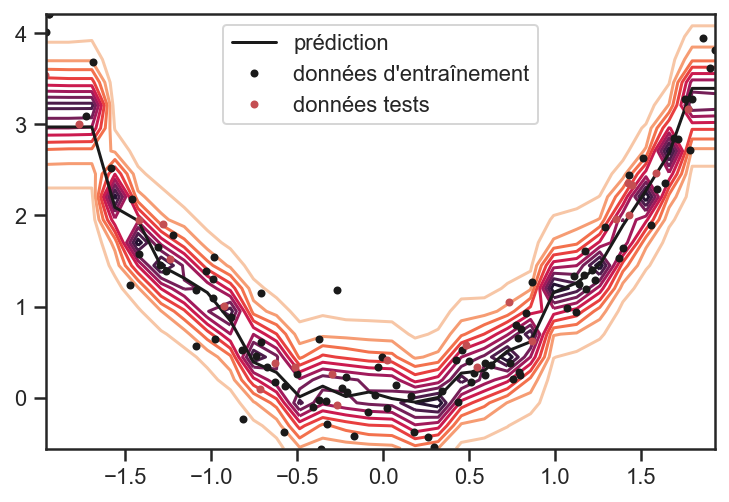

In [69]:
plt.contour(xlist.ravel(),ylist.ravel(), R.T, levels = np.linspace(0,1,11))

plt.plot(xlist, reg_neigh.predict(xlist.reshape(-1,1)).ravel(), 'k-', label = 'prédiction')
plt.plot(X_train,Y_train, 'k.', label = "données d'entraînement")
plt.axis([min(X_train),max(X_train),min(Y_train),max(Y_train)])
plt.plot(x_test,y_test,'r.', label='données tests')
plt.legend()
plt.show()

Passons maintenant à la méthode Jackknife +, méthode plus optimale que le full conformal, moins que le split conformal, mais néanmoins plus précise.

# METHODE JACKKNIFE +

In [70]:
def Jackknife_av_pred(x,X_train,Y_train,reg, alpha):
    n_train=X_train.shape[0]
    
    S_down, S_up = np.zeros(n_train), np.zeros(n_train)
    
    for i in range(n_train):
        Reg=reg
        
        Reg.fit(np.delete(X_train,i).reshape(-1,1),np.delete(Y_train,i).reshape(-1,1)) #ça nous donne le bon prédicteur 
        V_loo = np.abs(Y_train[i] - Reg.predict(X_train[i].reshape(-1,1))) #LOO residuals
        
        S_down[i] = Reg.predict(x.reshape(1,1)) - V_loo
        S_up[i] = Reg.predict(x.reshape(1,1)) + V_loo
    
    quantile_inf = np.quantile(S_down, alpha/2)
    quantile_sup = np.quantile(S_up, 1-alpha/2)
    
    return quantile_inf, quantile_sup

## Pour regréssion linéaire:

#### Entraînement des données

In [22]:
n=100
x = np.random.rand(n,1)
y = beta0*x + 1/2*np.random.randn(n,1)
y = np.ravel(y)

X_train, x_test, Y_train, y_test = train_test_split(x,y,test_size=0.2)
n_train = X_train.shape[0]
n_test = x_test.shape[0]

#### Tracé

## Pour les $k$-plus proches voisins ($k=9$)

In [23]:
n=120
x=4*np.random.rand(n,1) - 2
y = x**2 + 1/3*np.random.randn(n,1)
y=np.ravel(y)

X_train, x_test, Y_train, y_test = train_test_split(x,y,test_size=0.2)
n_train = X_train.shape[0]
n_test = x_test.shape[0]

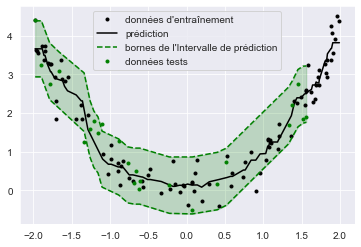

In [24]:
reg_neigh.fit(X_train,Y_train)
plt.plot(X_train, Y_train, 'k.',label="données d'entraînement")
idx = np.argsort(np.ravel(X_train))
plt.plot(X_train[idx], reg_neigh.predict(X_train[idx]), 'k-',label='prédiction')

idx = np.argsort(np.ravel(x_test))

low = np.zeros(n_test)
high = np.zeros(n_test)

for i in range(n_test):
    low[i], high[i] = Jackknife_av_pred(x_test[i],X_train,Y_train,reg_neigh, 0.1)

plt.plot(x_test[idx],low[idx], 'g--',label = "bornes de l'Intervalle de prédiction")
plt.plot(x_test[idx],high[idx],'g--')    
    
plt.fill_between(x_test[idx].reshape(-1,),low[idx].reshape(-1,),high[idx].reshape(-1,),color='green',alpha=.2)
plt.plot(x_test,y_test,'g.', label='données tests')

plt.legend()
plt.show()

# CV+ : Validation Croisée

In [25]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

## Code CV+

In [26]:
def cross_val(x, X_train, Y_train, reg, k_fold, alpha):
    n_train = X_train.shape[0]
    kf = KFold(n_splits= k_fold)
    
    R_loo = np.zeros(n_train)
    S_down, S_up = np.zeros(n_train), np.zeros(n_train)
    
    for id_train, id_val in kf.split(X_train):
        
        Reg = reg
        Reg.fit(X_train[id_train], Y_train[id_train])
        R_loo[id_val]=np.abs(Y_train[id_val] - Reg.predict(X_train[id_val].reshape(-1,1)))
        
        S_down[id_val] = Reg.predict(x.reshape(1,1)) - R_loo[id_val]
        S_up[id_val] = Reg.predict(x.reshape(1,1)) + R_loo[id_val]
    
    quantile_inf = np.quantile(S_down, alpha/2)
    quantile_sup = np.quantile(S_up, 1-alpha/2)
    
    return quantile_inf, quantile_sup

## Représentation graphique pour régression linéaire

In [27]:
n=100
x=np.random.rand(n,1)
y=beta0*x + 1/2*np.random.randn(n,1)
y=np.ravel(y)

X_train, x_test, Y_train, y_test = train_test_split(x,y,test_size=0.2)
n_train = X_train.shape[0]
n_test = x_test.shape[0]

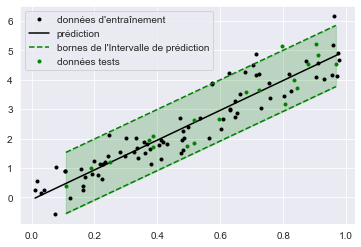

In [28]:
plt.plot(X_train, Y_train, 'k.',label="données d'entraînement")
idx = np.argsort(np.ravel(X_train))
plt.plot(X_train[idx], reg_OLS.predict(X_train[idx]), 'k-',label='prédiction')

idx = np.argsort(np.ravel(x_test))

low = np.zeros(n_test)
high = np.zeros(n_test)

for i in range(n_test):
    low[i], high[i] = Jackknife_av_pred(x_test[i],X_train,Y_train,reg_OLS, 0.1)

plt.plot(x_test[idx],low[idx], 'g--',label = "bornes de l'Intervalle de prédiction")
plt.plot(x_test[idx],high[idx],'g--')    
    
plt.fill_between(x_test[idx].reshape(-1,),low[idx].reshape(-1,),high[idx].reshape(-1,),color='green',alpha=.2)
plt.plot(x_test,y_test,'g.', label='données tests')

plt.legend()
plt.show()

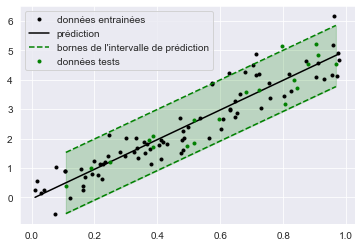

In [29]:
reg_OLS.fit(X_train,Y_train)

plt.plot(X_train, Y_train, 'k.',label='données entrainées')
idx = np.argsort(np.ravel(X_train))
plt.plot(X_train[idx], reg_OLS.predict(X_train[idx]), 'k-',label='prédiction')

idx = np.argsort(np.ravel(x_test))

low = np.zeros(n_test)
high = np.zeros(n_test)

for i in range(n_test):
    low[i], high[i] = cross_val(x_test[i],X_train,Y_train,reg_OLS, 80, 0.1)

plt.plot(x_test[idx],low[idx], 'g--',label = "bornes de l'intervalle de prédiction")
plt.plot(x_test[idx],high[idx],'g--')    
    
plt.fill_between(x_test[idx].reshape(-1,),low[idx].reshape(-1,),high[idx].reshape(-1,),color='green',alpha=.2)
plt.plot(x_test,y_test,'g.', label='données tests')

plt.legend()
plt.show()

## Représentation graphique pour k-plus proches voisins

In [30]:
n=100
x=4*np.random.rand(n,1)-2
y=x**2 + 1/8*np.random.randn(n,1)
y=np.ravel(y)

X_train, x_test, Y_train, y_test = train_test_split(x,y,test_size=0.2)
n_train = X_train.shape[0]
n_test = x_test.shape[0]

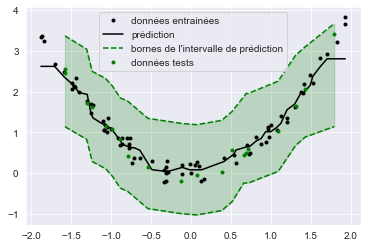

In [31]:
reg_neigh.fit(X_train,Y_train)

plt.plot(X_train, Y_train, 'k.',label='données entrainées')
idx = np.argsort(np.ravel(X_train))
plt.plot(X_train[idx], reg_neigh.predict(X_train[idx]), 'k-',label='prédiction')

idx = np.argsort(np.ravel(x_test))

low = np.zeros(n_test)
high = np.zeros(n_test)

for i in range(n_test):
    low[i], high[i] = cross_val(x_test[i],X_train,Y_train,reg_neigh, 5, 0.05)

plt.plot(x_test[idx],low[idx], 'g--',label = "bornes de l'intervalle de prédiction")
plt.plot(x_test[idx],high[idx],'g--')    
    
plt.fill_between(x_test[idx].reshape(-1,),low[idx].reshape(-1,),high[idx].reshape(-1,),color='green',alpha=.2)
plt.plot(x_test,y_test,'g.', label='données tests')

plt.legend()
plt.show()

# CLASSIFICATION

On va utiliser la méthode "Adaptive classification with split-conformal calibration", car c'est la plus facile à comprendre. Dans cette section, nous ne verrons pas le full conformal, trop couteux pour être intéressant.

### Split conformal :

Définition des fonctions que nous allons utiliser dans le split conformal :

In [32]:
def L(x, pi, tau):
    C = pi.shape[0]-1
    pi_sort = np.sort(pi)
    S = pi_sort[0,C-1]
    i=0
    while S < tau:
        i += 1
        S += pi_sort[0,C-i]
    return i

In [33]:
def V(x, pi, tau): 
    C = pi.shape[1]-1
    pi_sort = np.sort(pi)
    Sum = 0
    for k in range(L(x, pi, 1-tau)):
        Sum += pi_sort[0,C-k]
    
    return 1/pi_sort[0,C-L(x, pi, tau)]*(Sum - tau)

In [34]:
def S(x, U, pi, tau):
    C= pi.shape[1]-1
    if U <= V(x, pi, tau):
        return pi[0,:C-L(x, pi, tau)-1]
    else:
        return pi[0,:C-L(x, pi, tau)]

In [35]:
def E(x, y, U, pi):
    for k in range(0,1,101):
        if y.reshape(1,1) in S(x, U, pi, k):
            break
    return k

Algorithme :

#### Cet algorithme renvoie une famille de prédictions $y_{test}$ pour un $x_{test}$ donné.

data :

In [78]:
import sklearn
import pandas as pd
from sklearn.datasets import load_iris

In [79]:
plantes_iris = load_iris()
df_plantes_iris = pd.DataFrame(plantes_iris.data, columns=plantes_iris.feature_names)
df_plantes_iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [80]:
df_plantes_iris

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


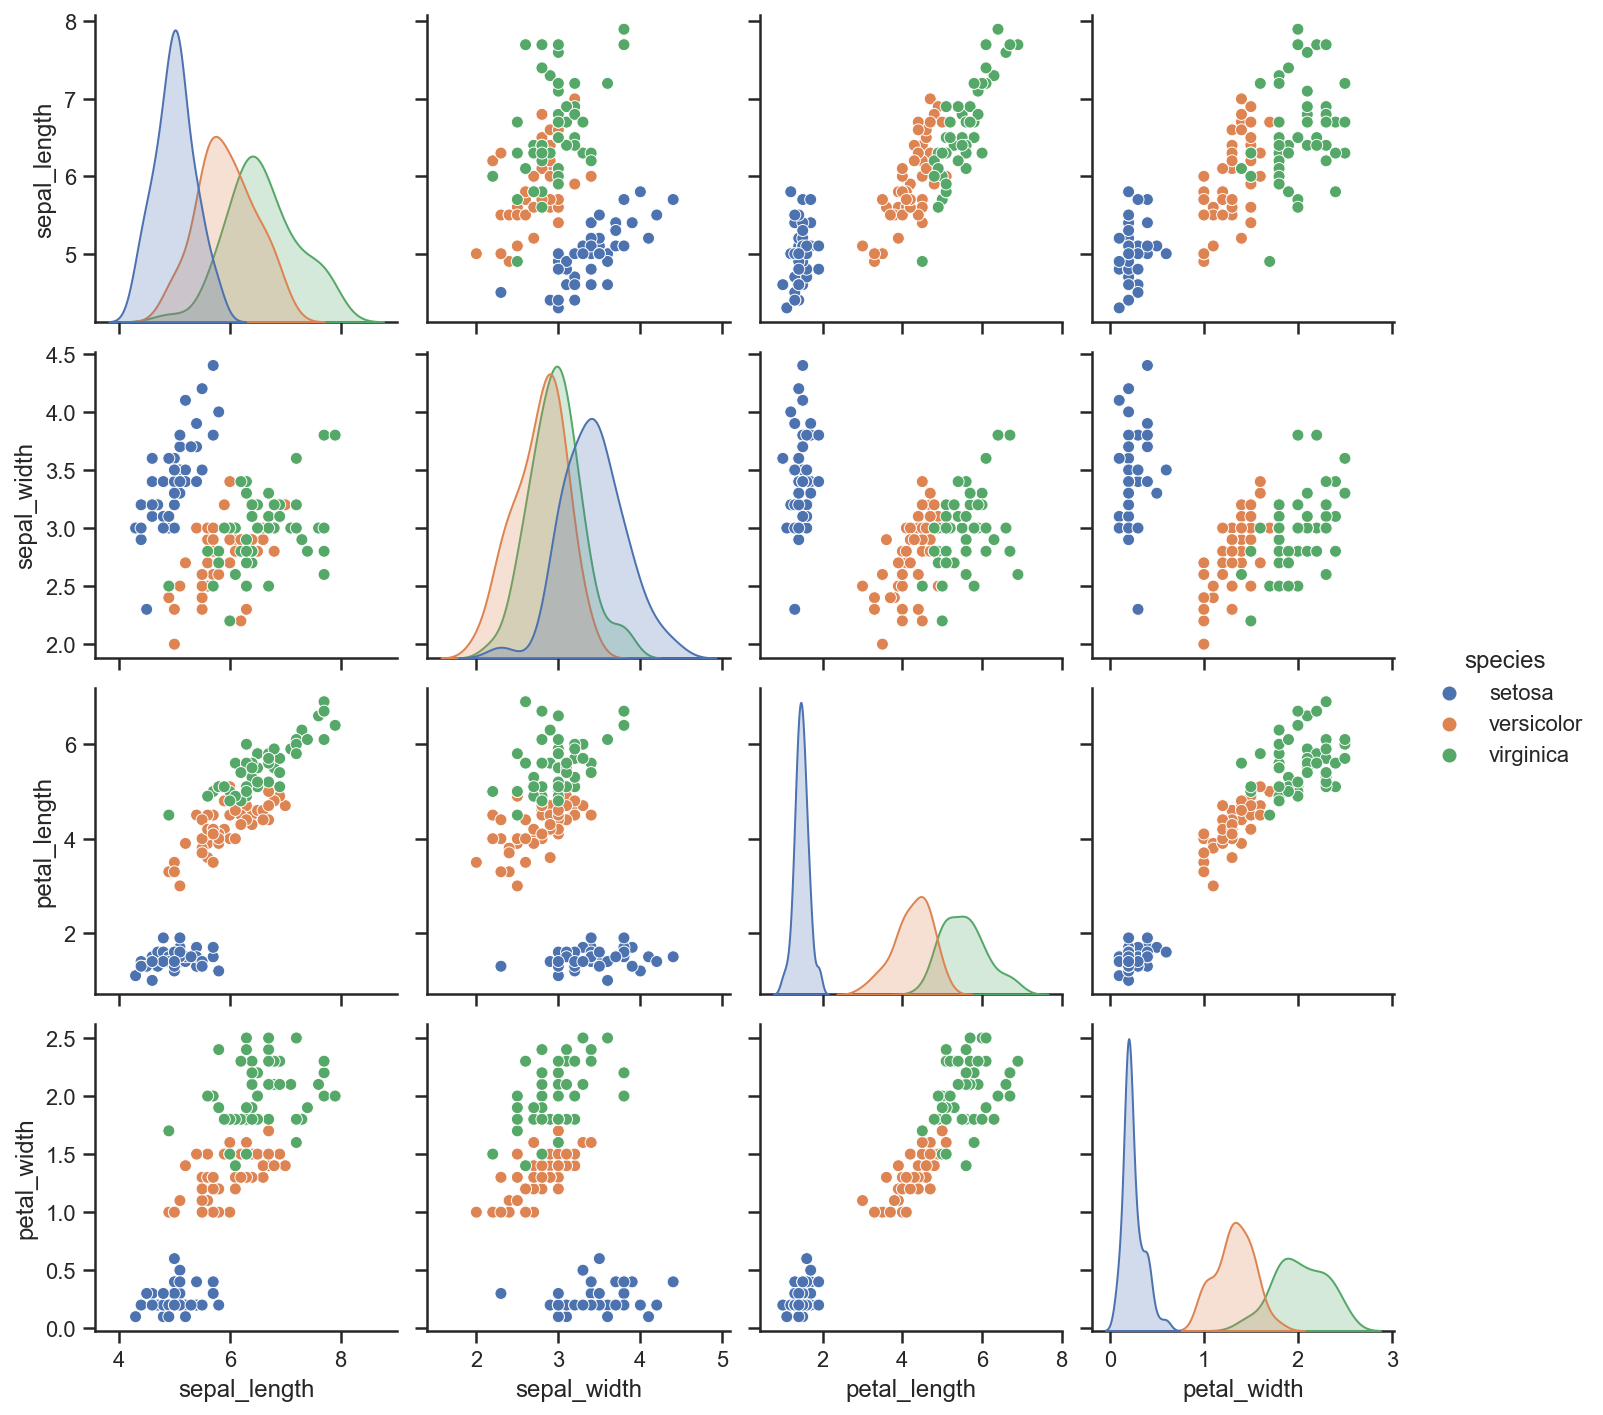

In [81]:
import seaborn as sns
sns.set(style="ticks", color_codes=True)
df_plantes_iris = sns.load_dataset("iris")
sns.pairplot(df_plantes_iris, hue="species")

In [82]:
df_plantes_iris

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [83]:
labels = np.asarray(df_plantes_iris.species)

In [84]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(labels)
labels = le.transform(labels)

In [85]:
df_selected1 = df_plantes_iris.drop(['sepal_length', 'sepal_width', "species"], axis=1)

In [86]:
df_features = df_selected1.to_dict(orient='records')
from sklearn.feature_extraction import DictVectorizer
vec = DictVectorizer()
features = vec.fit_transform(df_features).toarray()

voici finalement nos données d'entraînement et de calibration :

In [87]:
X_train, x_cal, Y_train, y_cal = train_test_split(features, labels, test_size=0.20, random_state=0)

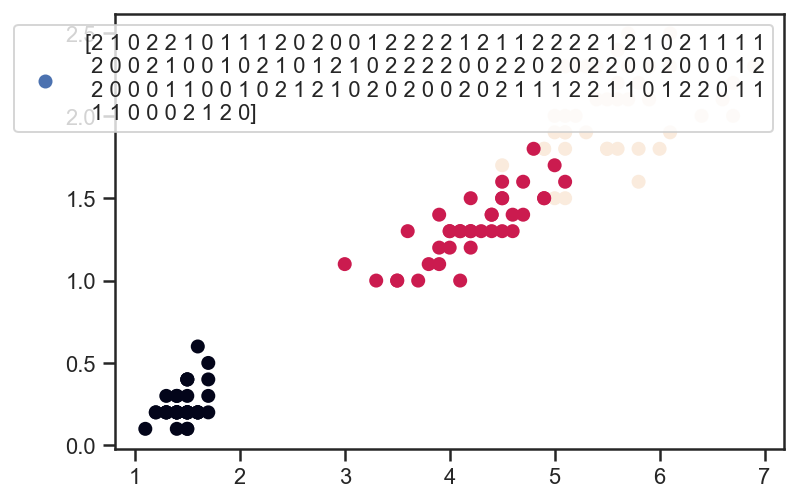

In [90]:
plt.scatter(X_train[:,0], X_train[:,1],  c = Y_train, label=Y_train)
plt.legend()

Créons maintenant notre prédicteur $\hat{\pi}$ :

In [92]:
from sklearn.neighbors import KNeighborsClassifier
reg_neigh = KNeighborsClassifier(n_neighbors = 9).fit(X_train, Y_train)

In [98]:
reg_neigh.predict_proba(x_cal)

array([[0.        , 0.        , 1.        ],
       [0.        , 1.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [0.        , 0.        , 1.        ],
       [1.        , 0.        , 0.        ],
       [0.        , 0.        , 1.        ],
       [1.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        ],
       [0.        , 0.88888889, 0.11111111],
       [0.        , 1.        , 0.        ],
       [0.        , 0.11111111, 0.88888889],
       [0.        , 0.88888889, 0.11111111],
       [0.        , 1.        , 0.        ],
       [0.        , 1.        , 0.        ],
       [0.        , 1.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [0.        , 0.88888889, 0.11111111],
       [0.        , 1.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [0.        , 0.11111111, 0.88888889],
       [0.        , 0.88888889, 0.11111111],
       [1.

In [ ]:
x_cal

In [ ]:
def SCP_classif(X_train, Y_train, x_cal, y_cal, x, reg, alpha = 0.1):
    
    n = X_train.shape[0]
    U = np.random.rand(n)
    
    reg.fit(X_train, Y_train)
    Es = np.zeros(x_cal.shape[0])
    for i in range(x_cal.shape[0]):
        Es[i] = E(x_cal[i].reshape(1,-1), y_cal[i], U[i], reg.predict_proba(x_cal[i].reshape(1,-1)))
    
    quantile = np.quantile(Es,(1-alpha)*(1+1/x_cal.shape[0]))
    
    pred_set = S(x, U[-1], reg.predict_proba(x), quantile)
    
    return pred_set

In [ ]:
SCP_classif(X_train, Y_train, x_cal, y_cal, [[5.5,1.5]], reg_neigh)

In [ ]:
reg_neigh.predict(x)

In [ ]:
print(plantes_iris.target_names[np.array(SCP_classif(X_train, Y_train, x_cal, y_cal, [[1.4,0.7]], reg_neigh)[0])])

In [99]:
print(5)

5
